In [60]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import lsst.sims.photUtils.Sed as Sed
import lsst.sims.photUtils.Bandpass as Bandpass
import os
from lsst.utils import getPackageDir

import lsst.sims.photUtils as pu

In [26]:
data = np.load('Kurucz_models.npz')

stellar_fluxes = data['stellar_fluxes'].copy()
properties = data['properties'].copy()
wave = data['wave'].copy()
data.close()



In [27]:
stellar_fluxes.shape, wave.shape

((1100, 225), (225,))

In [28]:
throughPath = os.path.join(getPackageDir('throughputs'), 'baseline')
lsstKeys = ['u', 'g', 'r', 'i', 'z', 'y']
# lsstKeys = ['r']
bps = {}
for key in lsstKeys:
    bp = np.loadtxt(os.path.join(throughPath, 'total_'+key+'.dat'),
                    dtype=zip(['wave', 'trans'], [float]*2))
    bpTemp = Bandpass()
    good = np.where(bp['trans'] > 0.)
    bpTemp.setBandpass(bp['wave'], bp['trans'], wavelen_min=bp['wave'][good].min(),
                       wavelen_max=bp['wave'][good].max())
    bps[key] = bpTemp


In [29]:
names = ['u', 'g','r', 'i', 'z', 'y']
types = [float]*6
lsst_mags = np.zeros(stellar_fluxes.shape[0], dtype=list(zip(names, types)))


In [30]:
for i in np.arange(lsst_mags.size):
    sed = Sed(wavelen=wave, flambda=stellar_fluxes[i,:])
    for filtername in names:
        lsst_mags[filtername][i] = sed.calcMag(bps[filtername])

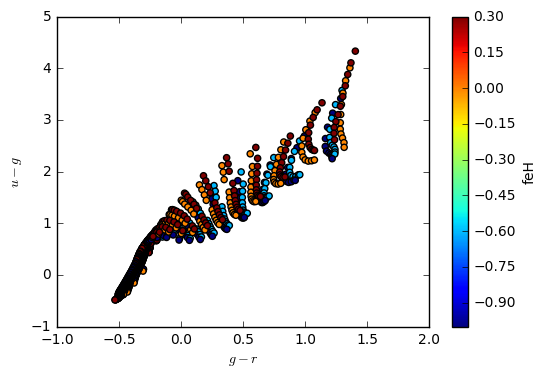

In [54]:
cprop = 'feH'
plt.scatter(lsst_mags['g']-lsst_mags['r'], lsst_mags['u']-lsst_mags['g'], c=properties[cprop])
plt.xlabel(r'$g-r$')
plt.ylabel(r'$u-g$')
cb = plt.colorbar()
cb.set_label(cprop)
#plt.xlim([-.6, 0.])

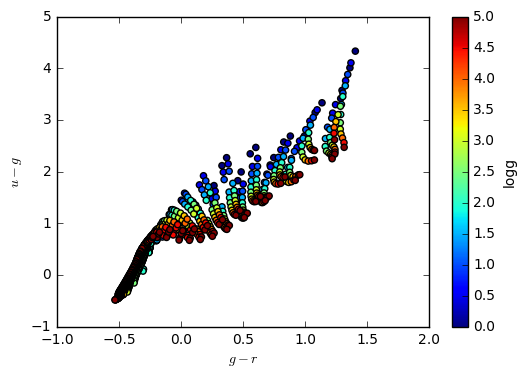

In [74]:
cprop = 'logg'
plt.scatter(lsst_mags['g']-lsst_mags['r'], lsst_mags['u']-lsst_mags['g'], c=properties[cprop])
plt.xlabel(r'$g-r$')
plt.ylabel(r'$u-g$')
cb = plt.colorbar()
cb.set_label(cprop)

In [52]:
np.unique(properties['logg'])

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ])

In [55]:
# XXX--now, let's just say we have the observed Gaia mags, and the gaia fit paramters are perfect, good, or bad
# and see what the recovered u-band looks like?


In [56]:
ack = np.load('0_33578_gum_mag_cat.npz')
stars = ack['result_cat'].copy()
ack.close()

In [61]:
# initialize the stellar SED cache
ack = pu.read_close_Kurucz(6000., 0., 20.)


Opening cache of LSST SEDs in:
/Users/yoachim/gitRepos/sims_photutils/cacheDir/lsst_sed_cache_2.p


/Users/yoachim/gitRepos/sims_photutils/python/lsst/sims/photUtils/Sed.py:1493: UserWarning: Multiple close files
  warnings.warn('Multiple close files')


In [63]:
# try to figure out what values were actually used
names = ['feH', 'logg','teff']
actual = np.zeros(stars.size, dtype=zip(names, [float]*3))


In [66]:
for i,star in enumerate(stars):
    temp_sed, temp_dict = pu.read_close_Kurucz(star['teff'], star['feH'], star['logg'])
    for key in actual.dtype.names:
        actual[key][i] = temp_dict[key]

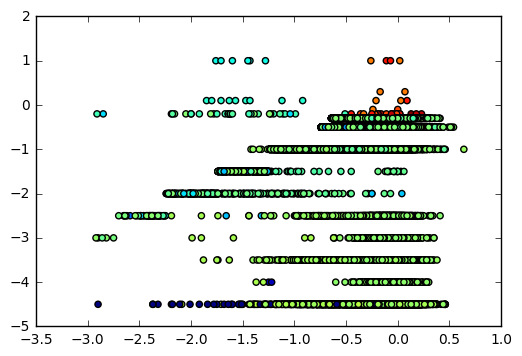

In [72]:
plt.scatter(stars['feH'], actual['feH'], c=stars['logg'])

In [75]:

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [175]:
# Let's make a simple polynomial model for fitting u-g given g-r, feH, and logg.
model = Pipeline([('poly', PolynomialFeatures(degree=5)),
                  ('linear', LinearRegression(fit_intercept=False))])

In [176]:
X = np.vstack((lsst_mags['g'] - lsst_mags['r'], properties['feH'], properties['logg']))
#X = np.vstack((properties['teff'], properties['feH'], properties['logg']))


In [177]:
model = model.fit(X.T,lsst_mags['u'] - lsst_mags['g'])

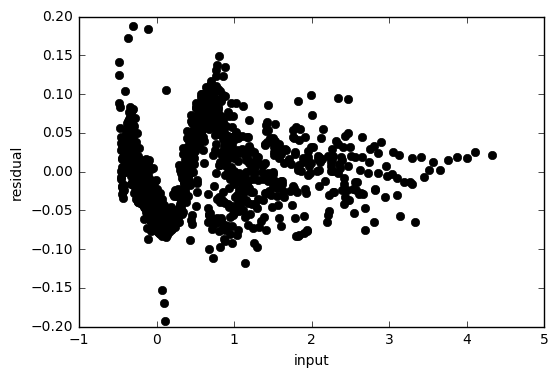

In [178]:
check = model.predict(X.T)
plt.plot(lsst_mags['u'] - lsst_mags['g'], (lsst_mags['u'] - lsst_mags['g']) - check, 'ko')
plt.xlabel('input')
plt.ylabel('residual')

In [182]:
# wow that sucks, let's try some scipy interpolation schemes
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator

In [183]:
interp = LinearNDInterpolator(X.T,lsst_mags['u'] - lsst_mags['g'])

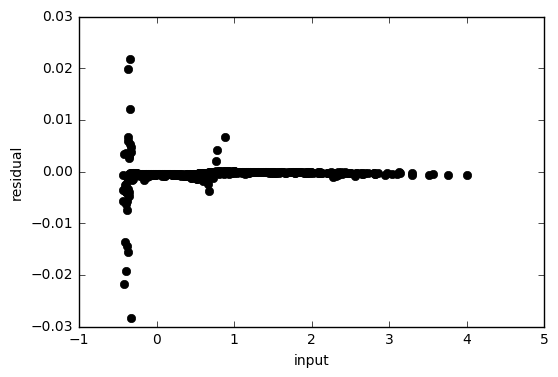

In [186]:
delta = .0001
check = interp(X.T+delta)
plt.plot(lsst_mags['u'] - lsst_mags['g'], (lsst_mags['u'] - lsst_mags['g']) - check, 'ko')
plt.xlabel('input')
plt.ylabel('residual')

In [ ]:
# XXX--ok, that looks like I can drop in measured values and get reasonable outputs.